https://earth.esa.int/documents/10174/1514862/Swarm_L2_IBI_product_description

In [1]:
from viresclient import SwarmRequest
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

request = SwarmRequest("https://staging.viresdisc.vires.services/openows")

start_time = dt.datetime(2016,1,1,9,7)
end_time = dt.datetime(2016,1,1,9,10)

request.set_collection("SW_OPER_IBIATMS_2F")
request.set_products(measurements=["Bubble_Index", "Bubble_Probability"])
IBI = request.get_between(start_time, end_time, asynchronous=False).as_dataframe()

request.set_collection("SW_OPER_EFIA_PL_1B")
request.set_products(measurements=["n","T_elec"])
EFI = request.get_between(start_time, end_time, asynchronous=False).as_dataframe()

request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(measurements=["B_NEC"],
                     models=["MCO_SHA_2C", "MLI_SHA_2C", "MMA_SHA_2C-Primary", "MMA_SHA_2C-Secondary"])
MAG = request.get_between(start_time, end_time, asynchronous=False).as_xarray()

      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.062MB)
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.062MB)
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.088MB)


In [2]:
B_res = MAG["B_NEC"] - MAG["B_NEC_MCO_SHA_2C"]\
                     - MAG["B_NEC_MLI_SHA_2C"]\
                     - MAG["B_NEC_MMA_SHA_2C-Primary"]\
                     - MAG["B_NEC_MMA_SHA_2C-Secondary"]
Z_res = B_res[:,2].to_dataframe(name="Z_res")

In [3]:
Z_res = Z_res.resample('500L').ffill()
IBI = IBI.resample('500L').ffill()
EFI = EFI.resample('500L').mean()
df = EFI.join( Z_res["Z_res"], how="outer").join(IBI[["Bubble_Index", "Bubble_Probability"]])
df.head()

,Latitude,Longitude,Radius,T_elec,n,Z_res,Bubble_Index,Bubble_Probability
Timestamp,,,,,,,,
2016-01-01 09:07:00.000,-16.934060,-52.120060,6830080.98,2414.90,240306.1,-1.422332,0.0,0.0
2016-01-01 09:07:00.500,-16.966064,-52.120531,6830084.89,2409.77,243403.2,-1.422332,0.0,0.0
2016-01-01 09:07:01.000,-16.998068,-52.121000,6830088.64,2406.33,244295.1,-1.686758,0.0,0.0
2016-01-01 09:07:01.500,-17.030072,-52.121469,6830092.54,2399.40,248306.5,-1.686758,0.0,0.0
2016-01-01 09:07:02.000,-17.062076,-52.121938,6830096.29,2415.25,244612.6,-2.152278,0.0,0.0


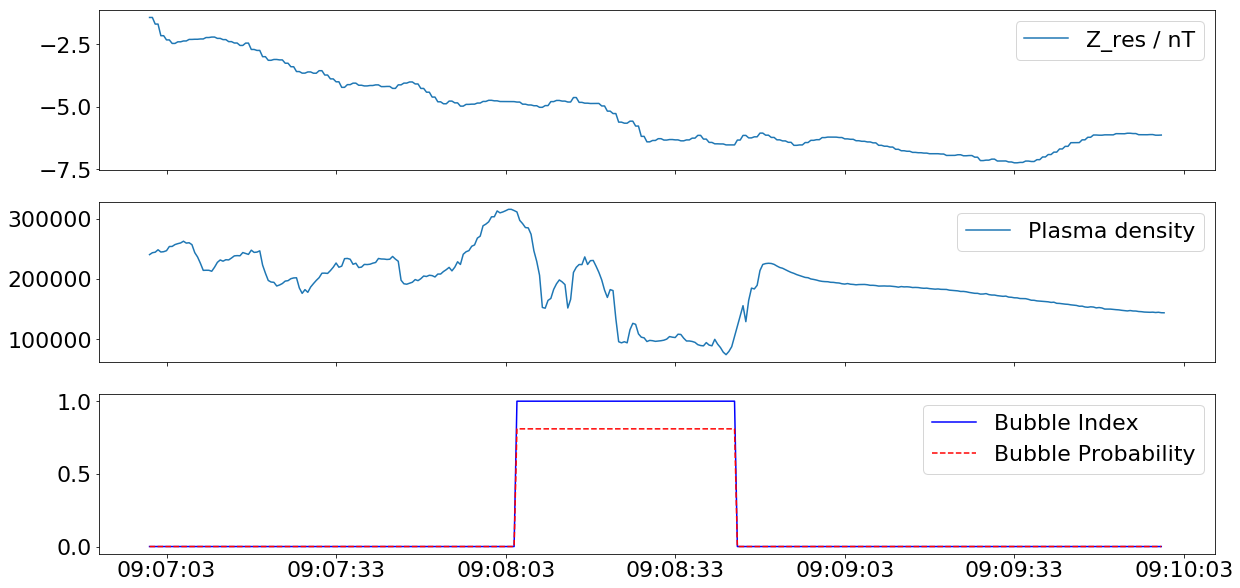

In [4]:
plt.rcParams.update({'font.size': 22})

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,10), sharex=True)
axes[0].plot(df['Z_res'], label='Z_res / nT')
axes[1].plot(df['n'], label='Plasma density')
axes[2].plot(df['Bubble_Index'], 'b-', label="Bubble Index")
axes[2].plot(df['Bubble_Probability'], 'r--', label="Bubble Probability")
for ax in axes:
    ax.legend()